# Loading necessary packages or libraries


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# A sound object
def sound():
    os.system('Z:/largetransfer/luc/carter/Isaac/Sosumi.aiff')

%matplotlib inline
sns.set_context('notebook')

wpath = 'Z:/largetransfer/luc/carter' #working from linux

lpath= "smb://WORKGROUP;ixo26@poprocks/dropbox/largetransfer/luc/carter" # working from linux

### Loading main data

In [2]:
data=pd.read_csv(wpath+'/data/model_data/tci_final1_10_10_2016.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

### loading complementary data
This data set is only  loaded in to collect specific data to be merged to the main data

In [3]:
data1=pd.read_csv('Z:/largetransfer/luc/carter/data/clean_data/tci_1_0.csv',parse_dates=[1])

C:\Users\Aisik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## encoding Survey Grades
def enSurveyGrade(x):
    if x == "F":
        return 1
    else:
        return 0
data1["survey_grade"]= data1["Survey Grade"].apply(enSurveyGrade)

In [5]:
### Total number of observations with grade F
sum(data1.survey_grade==1)

1531

#### Function to parse date data

In [6]:
def parsePin(x):
    x=str(x)
    return x[:3] + '-' +  x[3:5] + '-' + x[5:]
data1['PIN']=data1.PIN.apply(parsePin)

In [7]:
#subsetting data via nluc variable + attaching 'Survey grade' variable
ndata=pd.merge(data,data1[['PIN','survey_grade']],left_on ='parcel', right_on='PIN',how ='left')
ndata=ndata.loc[(ndata.nluc==5100.0) | (ndata.nluc==5200.0) | (ndata.nluc==5300.0),]
ndata["survey_grade"] = ndata.survey_grade.fillna(0)

In [8]:
#Number of F-graded parcels
sum(ndata.survey_grade == 1)

1396

In [ ]:
##subsetting residential data via plcass variable
ndata=ndata.ix[ndata.pclass=='Residential',]
ndata.drop('pclass',inplace=True,axis=1)

In [ ]:
condition_value = {0.0:'Unsound', 1.:'Sound', 2.:'Very poor', 3.:'Poor', 4.:'Fair', 5.:'Average', \
                   6.:'Good', 7.:'Very good', 8.:'Excellent'}
ndata['conditions']=ndata.condition_value14.map(condition_value)
ndata.conditions.fillna('Average',inplace=True)
ndata.drop('condition_value14',inplace=True, axis=1)
ndata.conditions.str.lower()

In [12]:
Good=['very good','excellent','good']
average=['fair','average','sound value']
poor=['unsound','poor','very poor']

def parseC(x):
    if x.lower() in Good:
        return 'good'
    elif x.lower() in average:
        return 'average'
    else: return 'poor'
ndata['condition']=ndata.conditions.apply(parseC)
ndata.drop('conditions',axis=1,inplace=True)
ndata.drop('PIN', axis=1, inplace=True)

In [13]:
ndata.reset_index(inplace=True)
cond_dummy= pd.get_dummies(ndata.condition) 
cond_dummy['parcel']=ndata.parcel
ndata= pd.merge(ndata, cond_dummy,left_on='parcel', right_on= 'parcel',how='left')
ndata.set_index('parcel', inplace=True)
ndata.drop('index', axis=1, inplace = True)

In [14]:
#Removing certain features from the data set
t = list(ndata.columns)
for i in ['vacant_block'\
          'part_one_crimes','part_two_crimes',
          'white','asian','other','hispanic','young','middle','old','nluc','vacant',"survey_grade",\
        ]:
    if i in t:
        t.remove(i)
    
features = t


In [49]:
X_train,X_test,y_train,y_test=train_test_split(ndata[features],ndata["survey_grade"],test_size=0.2,random_state=7)

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(88503, 48)
(22126, 48)
(88503,)
(22126,)


In [50]:
X_train1=X_train.drop(['condition','NAME10'],axis=1)
X_test1=X_testr=X_test.drop(['condition','NAME10'],axis=1)

#  Building models


### Fitting Random Forest

In [170]:

from scipy.stats import randint as sp_randint
from sklearn.externals import joblib
from time import time

n_trees=list(range(40,81))
n_features=list(range(20,31))

# param_grid=dict(n_estimators=n_trees,max_features=n_features)
start_time=time()

param_dist=dict(n_estimators=sp_randint(50,81),max_features=sp_randint(20,31))
    
rfc=RandomForestClassifier(class_weight={0:1,1:10},random_state=6)
# grid_rfc=GridSearchCV(rfc,param_grid,cv=10,scoring="accuracy") 
rand_rfc=RandomizedSearchCV(rfc, param_dist,cv=10,scoring="accuracy",n_iter=10)

# grid_rfc.fit(X_train,y_train)
rand_rfc.fit(X_train1,y_train)

joblib.dump(rand_rfc, "Z:/largetransfer/luc/carter/Isaac/model_files/rand_rfc_grade.pkl")

end_time=time()-start_time
sound()

### Fitting Gradient Boosting

In [171]:
from scipy.stats import randint as sp_randint
from time import time
from itertools import islice,count
from sklearn.externals import joblib

start=time()

param_dist=dict(n_estimators= sp_randint(200,250),\
                max_features= sp_randint(20,30),\
                max_depth= sp_randint(2,10),\
               learning_rate =list(islice(count(0.01,0.01),0,10)))
         
gbm=GradientBoostingClassifier(random_state=10)

rand_gbm=RandomizedSearchCV(gbm,param_dist,cv=10,scoring='accuracy',n_iter=5)

rand_gbm.fit(X_train1,y_train)

joblib.dump(rand_gbm,"Z:/largetransfer/luc/carter/Isaac/model_files/rand_gbm_grade.pkl")

end_time=time()-start
sound()

### Fitting logistic regression

In [21]:
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.externals import joblib
start_time=time()
# Scaling features

X_train1=StandardScaler().fit_transform(X_train1)
#X_test1=StandardScaler().fit_transform(X_test1)

# Parameter options using the l1 penalty
grid_param1={'penalty':['l2'],\
           'solver':['newton-cg'],\
           'C':[ 0.001,0.01, 0.1, 1, 10,100,1000]}

log_reg1=LogisticRegression(tol=0.0001, max_iter=300,class_weight={0:1,1:10})

# Creating gridsearch obj using the above setings
grid_reg1=GridSearchCV(log_reg1,grid_param1,cv=10,scoring='accuracy',error_score=0)

grid_reg1.fit(X_train1,y_train)

joblib.dump(grid_reg1,'Z:/largetransfer/luc/carter/Isaac/model_files/logistic_reg_grade.pkl')

total_time=time()-start_time

sound()


## Making predictions

In [22]:
from sklearn.externals import joblib
logistic=joblib.load('Z:/largetransfer/luc/carter/Isaac/model_files/logistic_reg_grade.pkl')
gradientB=joblib.load('Z:/largetransfer/luc/carter/Isaac/model_files/rand_gbm_grade.pkl')
RandomF=joblib.load("Z:/largetransfer/luc/carter/Isaac/model_files/rand_rfc_grade.pkl")

### Logistic

In [23]:
#Best model after the Randomized search
logistic.best_estimator_

LogisticRegression(C=0.001, class_weight={0: 1, 1: 10}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [25]:
#Checking the parameters used for the model selection
logistic.best_params_

{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}

In [38]:
#predicted values
from sklearn.preprocessing import StandardScaler
X_testlg=StandardScaler().fit_transform(X_testr)
predicted=logistic.predict(X_testlg)


In [27]:
#Measuring model accuracy
metrics.accuracy_score(y_test,predicted)

0.96904094730181689

In [28]:
#This is contain the same information as the cell that immediately follows it
metrics.confusion_matrix(y_test,predicted)

array([[21242,   600],
       [   85,   199]])

In [44]:
pd.crosstab(y_test,predicted, margins=True,colnames=['predicted'],rownames=['Actual'])

predicted,0.0,1.0,All
Actual,,,
0.0,21242,600,21842
1.0,85,199,284
All,21327,799,22126


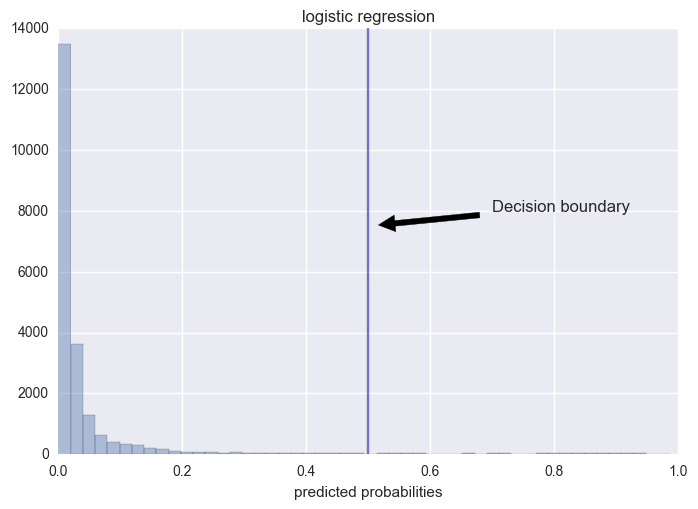

In [45]:
# Visualizing the distribution of the  predicted probabilities
# sns.set_style('white')

predprob=logistic.predict_proba(X_testlg)[:,1]

def distprob(predprob,threshold,model='',adjusted=False):
    """Utility for plotting the distribution probability"""
    
    sns.distplot(predprob,kde=False)
    plt.axvline(threshold,color='DarkBlue', alpha=0.5)
    plt.xlabel('predicted probabilities')
    ax=plt.gca()
    ax.annotate('Decision boundary', xy=(threshold,7500), xytext=(threshold+0.2,8000),
                arrowprops=dict(facecolor='black', shrink=0.08),
                )
    if adjusted:
        plt.title(model +' with adjusted threshold:%.2f'%threshold)
    else:
        plt.title(model)


    
distprob(predprob,0.5,'logistic regression')

In [33]:
dsource=pd.read_excel('Z:/largetransfer/luc/carter/data/model_data/model_variables_and_sources.xlsx')
dsource=dsource.rename(columns={'Variable names':'variables'})
dsource['source']=dsource.source.str.lower()
dsource['variables']=dsource.variables.str.lower()
# dsource

In [77]:
#Coefficients of the model
coef=logistic.best_estimator_.coef_.T[:X_testr.shape[1]].ravel()
# coef=logistic.best_estimator_.coef_.T.ravel()
var=X_test1.columns.values[:X_test1.shape[1]]
df=pd.DataFrame(dict(list(zip(['variables','coef'],[var,coef]))))
df['variables']=df.variables.str.lower()
df=pd.merge(df,dsource[['variables','source']],on='variables',how='left')
df.loc[df.variables=='bachelors.','source']='demographics'
df.loc[df.variables=='v_total_2yr','source']='violations'
df.loc[df.variables=='c_ovv_board_num','source']='complaints'
df.loc[df.variables== 'c_ovv_num','source']='complaints'
df.loc[df.variables=='fc_days','source']='foreclosure'
# df.iloc[df.shape[0]-4:,'source']='condition'
df=df.fillna('condition',axis=1)
df['source']=df.source.str.replace('_',' ')
df['source']=df.source.str.capitalize()
    
sources=set(df.source)
for s in sources:
    l=df.ix[df.source==s,].shape[0]
    idx=df.ix[df.source==s,].index.values
    if l != 1:
        for i in range(l):
            df.loc[df.index==idx[i],'source']= s + str(i)


In [74]:
# Tuning the prediction probabilities and setting roc_curve
adjusted_prediction=np.where(predprob>0.9,1,0)

In [75]:
pd.crosstab(y_test,adjusted_prediction,colnames=['predicted'],rownames=['Actual'])

predicted,0,1
Actual,,
0.0,21786,56
1.0,243,41


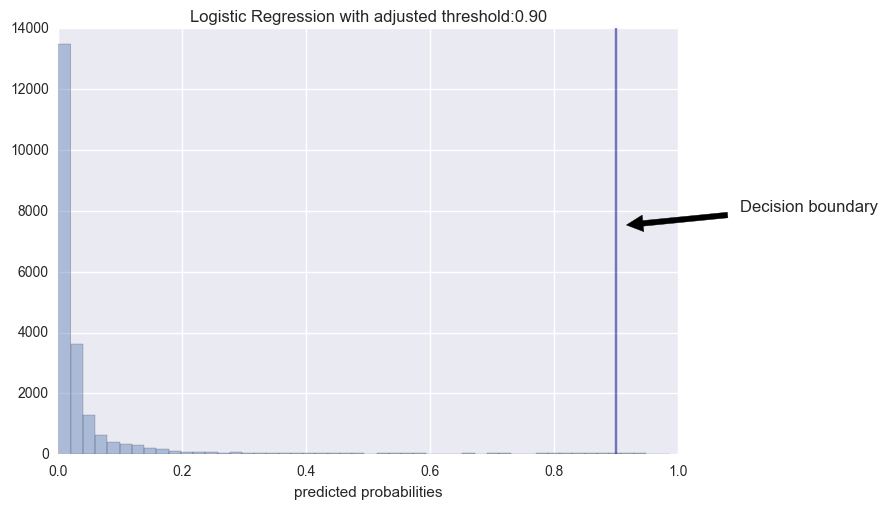

In [76]:
#adjusting the decision line to 0.8
distprob(predprob,0.9,adjusted=True, model='Logistic Regression')

### Random Forest

In [78]:
features=df.source

In [80]:
RandomF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features=21,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=58, n_jobs=1,
            oob_score=False, random_state=6, verbose=0, warm_start=False)

In [81]:
important_features=RandomF.best_estimator_.feature_importances_
feature_map=dict(zip(['features','values'],[features,important_features]))
pd.DataFrame(feature_map).head()

,features,values
0,Residential,0.004356
1,Main property0,0.020362
2,Main property1,0.024570
3,Main property2,0.025201
4,Main property3,0.001852


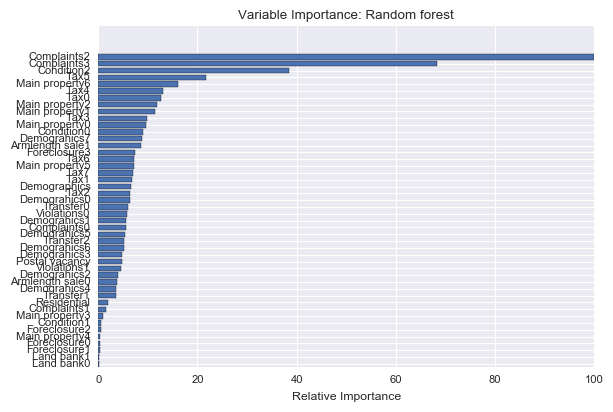

In [99]:
#variable importance plotting utility


def important_feature_plot(variables,values,model=''):
    # Plot feature importance
    sns.set_context('paper')    # There are other contexts you can set: "talk", "notebook", "poster"

    # make importances relative to max importance
    features1=np.array(variables)
    feature_importance = 100.0 * (values / values.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
#     plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos,features1[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance: '+ model)
    plt.show()
    
# feature_lab=['Residential 1','Main property 1','Main property 1','Main property 2','Main property 3','Main property 4'\
#             ,'Main property 5','Demographics','Land & Banks 1','Land & Banks 2','Tax 1','Tax 2','Tax 3','Tax 4','Tax 5','Tax 6'\
#             ,'Tax 7','Tax 8','Postal vacancy','Violations 1','Violations 2','Complaints 1','Complaints 2','Complaints 3','Complaints 4',\
#             'Foreclosure 1','Foreclosure 2','Foreclosure 3','Foreclosure 4','Transfer 1','Transfer 2','Transfer 3','Armslength 1','Armslength 2',\
#             'Tax 9']

important_feature_plot(features,important_features,'Random forest')

In [83]:
#Making a prediction
predicted_rf=RandomF.predict(X_test1)
pd.crosstab(y_test,predicted_rf,colnames=['predicted'],rownames=['Actual'])

predicted,0.0,1.0
Actual,,
0.0,21817,25
1.0,262,22


In [84]:
print('Calculated score: %.5f \n RandomizedScore: %.5f'%(metrics.accuracy_score(y_test,predicted_rf),RandomF.best_score_))

Calculated score: 0.98703 
 RandomizedScore: 0.98746


In [53]:
#prediction probability
# prob_rf=RandomF.predict_proba(X_test1)[:,1]
# plt.subplot(211)
# distprob(prob_rf,0.5,model='Random Forest')
# plt.subplot(212)
# distprob(prob_rf,0.4,model='Random Forest', adjusted=True)

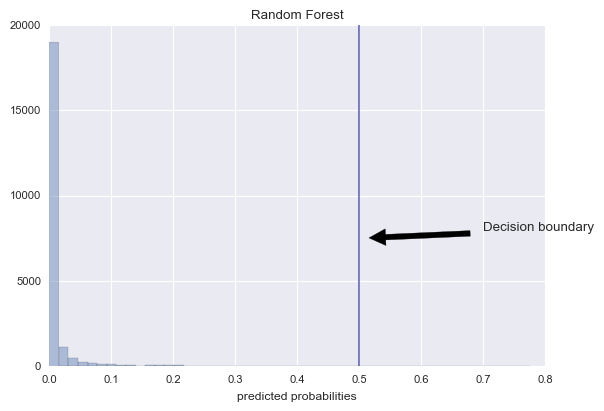

In [98]:
#prediction probability
prob_rf=RandomF.predict_proba(X_test1)[:,1]
with sns.plotting_context("paper"):
    distprob(prob_rf,0.5,model='Random Forest')


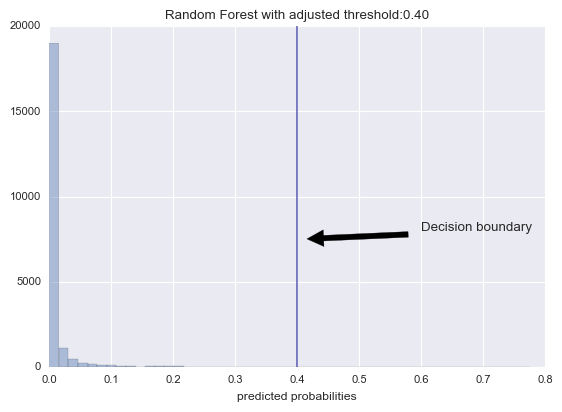

In [97]:
#prediction probability
prob_rf=RandomF.predict_proba(X_test1)[:,1]
with sns.plotting_context("paper"):
    distprob(prob_rf,0.4,model='Random Forest', adjusted=True)

In [87]:

#Adjusting the thresholds and setting the roc curves
newpred_rf=np.where(prob_rf>0.4,1,0)

pd.crosstab(y_test,newpred_rf,colnames=['predicted'],rownames=['Actual'])

predicted,0,1
Actual,,
0.0,21780,62
1.0,236,48


### Gradient Boosting


In [88]:
#checking the best estimator obtained from the Randomized grid parameter search
gradientB.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.060000000000000005, loss='deviance',
              max_depth=4, max_features=20, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=234, presort='auto', random_state=10,
              subsample=1.0, verbose=0, warm_start=False)

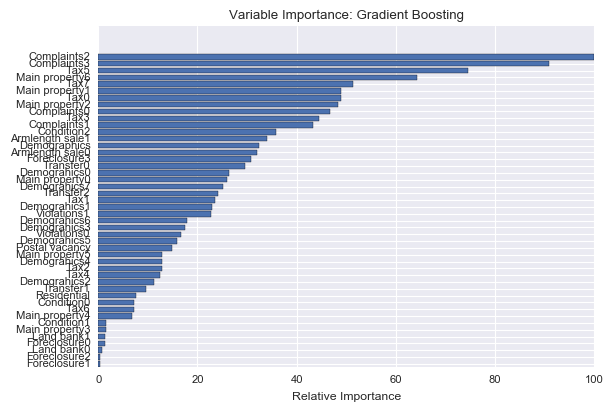

In [100]:
important_feat=gradientB.best_estimator_.feature_importances_

important_feature_plot(features,important_feat,'Gradient Boosting')

In [90]:
predictedgb=gradientB.predict(X_test1)

In [91]:
pd.crosstab(y_test,predictedgb,colnames=['predicted'],rownames=['Actual'])

predicted,0.0,1.0
Actual,,
0.0,21795,47
1.0,241,43


In [92]:
#Accuracy score
metrics.accuracy_score(y_test,predictedgb)

0.98698363915755216

In [59]:
# prob_gbm=gradientB.predict_proba(X_test1)[:,1]
# plt.subplot(211)
# distprob(prob_gbm,0.5,model='Gradient Boosting')
# plt.subplot(212)
# distprob(prob_gbm,0.2,model='Gradient Boosting', adjusted=True)

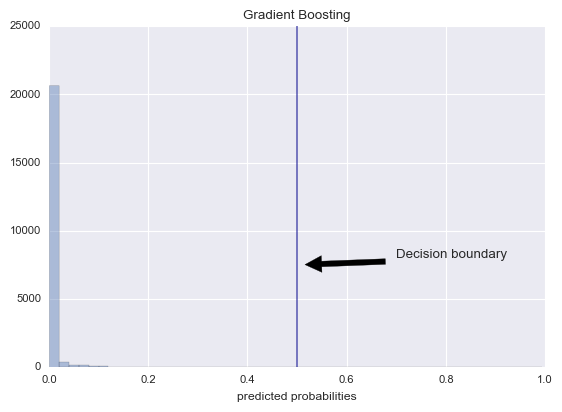

In [101]:
prob_gbm=gradientB.predict_proba(X_test1)[:,1]

distprob(prob_gbm,0.5,model='Gradient Boosting')


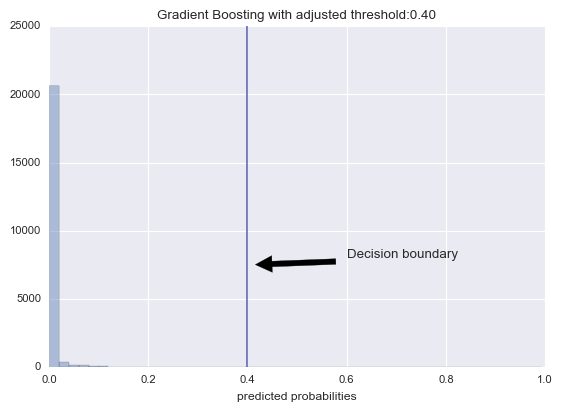

In [102]:
prob_gbm=gradientB.predict_proba(X_test1)[:,1]

distprob(prob_gbm,0.4,model='Gradient Boosting', adjusted=True)

In [103]:
adjustpredgb=np.where(prob_gbm>0.4,1,0)
pd.crosstab(y_test,adjustpredgb,colnames=['Predicted'],rownames=['Actual'])

Predicted,0,1
Actual,,
0.0,21762,80
1.0,214,70


### ROC Curve

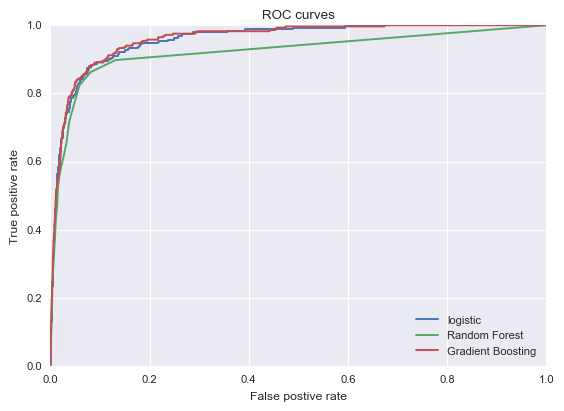

In [106]:
def roc_curve(actual,score,model=''):
    fpr,tpr,thresholds=metrics.roc_curve(actual,score)
    plt.plot(fpr,tpr,label=model)
    plt.title('ROC curves')
    plt.xlabel('False postive rate')
    plt.ylabel('True positive rate')
    
roc_curve(y_test,predprob,'logistic')
plt.hold('on')
roc_curve(y_test,prob_rf,'Random Forest')
plt.hold('on')
roc_curve(y_test,prob_gbm,'Gradient Boosting')
plt.hold('off')
plt.legend(loc='lower right')

### Specificity and sensitivity of models

In [107]:

model_predictions=[predicted,predicted_rf,predictedgb]
print('Summary of model performance')
for i,pred in enumerate(model_predictions):
    if i == 1:
        print("For Logistic model")
    elif i == 2:
        print('For random forest')
    else:
        print('for gradient boosting')
        
    print(metrics.classification_report(y_test,pred))
    print('\n')

Summary of model performance
for gradient boosting
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     21842
        1.0       0.25      0.70      0.37       284

avg / total       0.99      0.97      0.98     22126



For Logistic model
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     21842
        1.0       0.47      0.08      0.13       284

avg / total       0.98      0.99      0.98     22126



For random forest
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     21842
        1.0       0.48      0.15      0.23       284

avg / total       0.98      0.99      0.98     22126





### Writing out predictions to disk

In [108]:
results=pd.DataFrame({'Logistic':predicted,'Random_forest':predicted_rf,'Gradient_Boosting':predictedgb})
# results.to_csv('C:\\Users\\senatoduro8\\Poverty_center\\Predictions.csv')
results.to_csv('Z:/largetransfer/luc/carter/Isaac//Predictions_10_14_2016_graded.csv')

### Files for buffering

In [66]:

predictions=pd.read_csv('Z:/largetransfer/luc/carter/data/predictions/Predictions_10_14_2016.csv')

In [84]:
X_test.reset_index(inplace=True)

In [91]:
# data=pd.merge(pd.DataFrame(y_test).reset_index(),predictions,right_index=True,left_index=True,how='inner').drop('Unnamed: 0',axis=1)
df=pd.merge(data,X_test[['parcel','NAME10','Survey Grade']],left_on='parcel',right_on='parcel',how='outer').rename(columns={'NAME10':'census_track'})


In [92]:
df.to_csv('Z:/largetransfer/luc/carter/data/predictions/predictions_10_14_2016.csv')